# Pipelines in procesi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Algorithm Chains and Pipelines

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)

# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


### Parameter Selection with Preprocessing

In [4]:
from sklearn.model_selection import GridSearchCV

# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


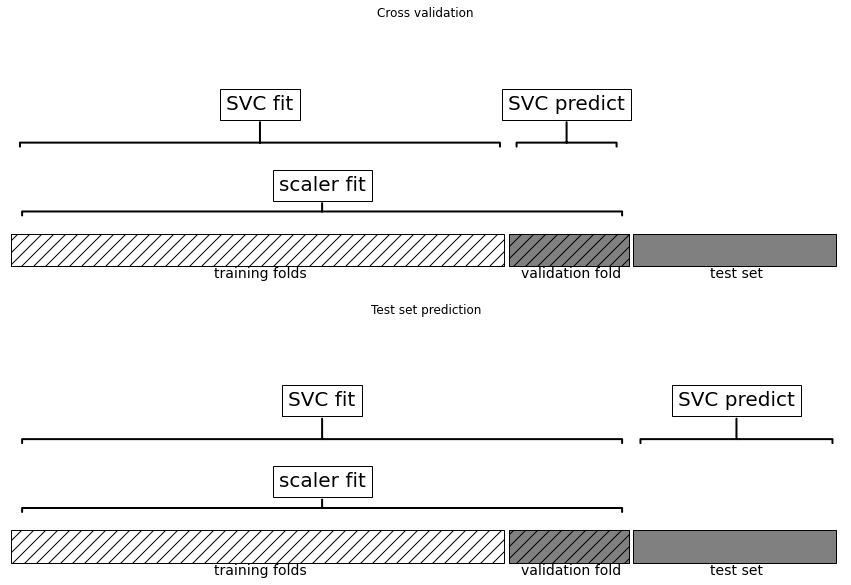

In [5]:
from helper_plots import plot_improper_processing
plot_improper_processing()

### Building Pipelines

In [6]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [7]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [8]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


### Using Pipelines in Grid Searches

In [9]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

# to so pravila kako poimenujemo pipeline

In [10]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


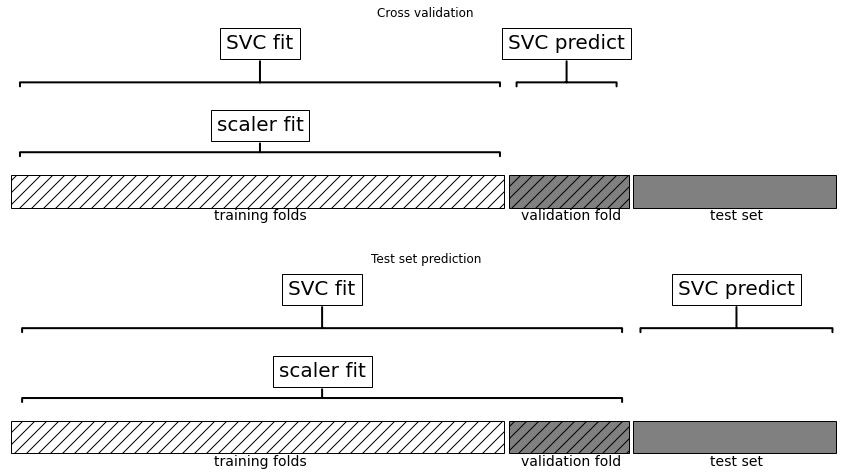

In [11]:
from helper_plots import plot_proper_processing
plot_proper_processing()

### The General Pipeline Interface

```python
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self
```

```python
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # fit the last step
    return self.steps[-1][1].predict(X_transformed)
```

### Convenient Pipeline Creation with make_pipeline

In [12]:
from sklearn.pipeline import make_pipeline

# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])

# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [13]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


### Accessing Step Attributes

In [15]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)

# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_

print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


### Accessing Attributes in a Pipeline inside GridSearchCV

In [16]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [17]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [18]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [19]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [20]:
print("Logistic regression step:\n{}".format(grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1, max_iter=1000)


In [21]:
print("Logistic regression coefficients:\n{}".format(grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


### Grid-Searching Preprocessing Steps and Model Parameters

In [22]:
from sklearn.datasets import load_boston

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,random_state=0)

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [24]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [25]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

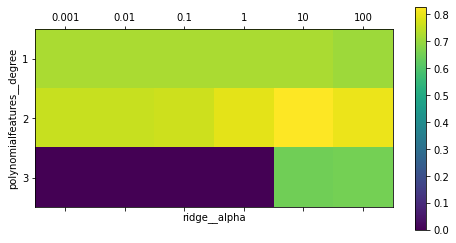

In [26]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),param_grid['polynomialfeatures__degree'])
plt.colorbar()
plt.show()

In [27]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [28]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [29]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


### Grid-Searching Which Model To Use

In [30]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [31]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'classifier': [SVC()], 
               'preprocessing': [StandardScaler(), None],
                'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
               {'classifier': [RandomForestClassifier(n_estimators=100)],
                'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.98


## Choosing the right estimator

<img src="https://scikit-learn.org/stable/_static/ml_map.png" class="map" alt="Move mouse over image" usemap="#imgmap">

## Primer 1: Titanic

In [33]:
import numpy as np
import pandas as pd

**Dataset details**

In [34]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

In [35]:
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [36]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: category
Categories (2, object): ['0', '1']

In [37]:
# hočemo najprej razumet koliko je manjkajočih vrednosti, kakšni so podatki.
# Uporabimo lahko Pandas Profiling.

**Profiling Report using Pandas Profiling**

In [38]:
#!pip install pandas_profiling[notebook]

In [39]:
from pandas_profiling import ProfileReport

In [40]:
import matplotlib.pyplot as plt

In [41]:
combine_dataset = pd.concat([X,y], axis=1)
profile_report = ProfileReport(combine_dataset)
profile_report.to_widgets()
profile_report.to_file("data/titanic_profiling_report.html")

### Creating Data Transformer Pipeline

In [42]:
# numerical features from the dataset
numerical_features = ['age', 'fare']

# categorical features from the dataset
categorical_features = ['embarked', 'sex', 'pclass']

**Imputing Data**

In [49]:
from sklearn.impute import SimpleImputer

In [50]:
X_copy = X.copy()

In [51]:
impute_age = SimpleImputer(strategy="mean")

In [52]:
X_copy['age_imputed'] = impute_age.fit_transform(X[['age']])

In [53]:
X_copy[X_copy['age'].isna()].head(2)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,age_imputed
15,1.0,"Baumann, Mr. John D",male,NaN,0.0,0.0,PC 17318,25.925,None,S,None,NaN,"New York, NY",29.881135
37,1.0,"Bradley, Mr. George ('George Arthur Brayton')",male,NaN,0.0,0.0,111427,26.550,None,S,9,NaN,"Los Angeles, CA",29.881135


**Scaling data**

In [54]:
minmax_scaler = MinMaxScaler()

In [55]:
X_copy['age_scaled'] = minmax_scaler.fit_transform(X[['age']])

**One Hot Encoding**

In [57]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()

In [58]:
one_hot_encoder.fit_transform(X_copy[['embarked_imputed']]).toarray()

KeyError: "None of [Index(['embarked_imputed'], dtype='object')] are in the [columns]"

**Building Pipeline**

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [60]:
numerical_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer()),
                                    ('scaler', 'passthrough')])

In [61]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

In [62]:
categorical_transformer = Pipeline(steps=[
                                        ('imputer', SimpleImputer()),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [63]:
from sklearn.compose import ColumnTransformer 

data_transformer = ColumnTransformer(
                    transformers=[
                        ('numerical', numerical_transformer, numerical_features),
                        ('categorical', categorical_transformer, categorical_features)])

In [64]:
from sklearn.decomposition import PCA

In [65]:
# Creating preprocessor pipeline which will first transform the data
# and then apply PCA.
preprocessor = Pipeline(steps=[('data_transformer', data_transformer),
                             ('reduce_dim',PCA())])

**Adding Classifier to the Pipeline**

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
classifier = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=0, max_iter=10000))])

**Applying GridSearchCV**

In [68]:
from sklearn.model_selection import train_test_split            
from sklearn.model_selection import GridSearchCV

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

In [70]:
param_grid = {
    'preprocessor__data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__data_transformer__categorical__imputer__strategy': ['constant','most_frequent'],
    'preprocessor__data_transformer__numerical__scaler': [StandardScaler(), RobustScaler(), \
                                                          MinMaxScaler()],
    'classifier__C': [0.1, 1.0, 10, 100],
    'preprocessor__reduce_dim__n_components': [2, 5, 10],
    'classifier__solver': ['liblinear','newton-cg', 'lbfgs','sag','saga']
}

In [71]:
grid_search = GridSearchCV(classifier, param_grid=param_grid, verbose=4, n_jobs=-1, cv=5)

In [72]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           'passthrough')]),
                                                                                          ['age',
                                                                                           'fare']),
                                                             

**Visualizing Pipeline**

In [73]:
from sklearn import set_config                      
from sklearn.utils import estimator_html_repr      

In [74]:
set_config(display='diagram')

In [75]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'fare']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='constant')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['embarked',
                                                                    'sex',
                                                                    'pclass'])])),
                                 ('reduce_dim', PCA(n_components=10))])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=10000, random_state=0,
                                    solver='newton-cg'))])

In [76]:
from sklearn.utils import estimator_html_repr
with open('data/titanic_data_pipeline_estimator.html', 'w') as f:  
    f.write(estimator_html_repr(grid_search.best_estimator_))

**Evaluating Model**

In [77]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [78]:
y_pred = grid_search.predict(X_test)

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       203
           1       0.78      0.69      0.73       125

    accuracy                           0.81       328
   macro avg       0.80      0.78      0.79       328
weighted avg       0.81      0.81      0.81       328



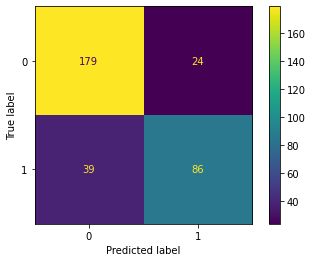

In [80]:
plot_confusion_matrix(grid_search, X_test, y_test)
plt.show()

In [81]:
grid_search.score(X_test, y_test)

0.8079268292682927